# Customer Churn

![](https://www.quantiphi.com/wp-content/uploads/2017/06/insurance-customer-churn-analytics.jpg)

Data from https://www.kaggle.com/blastchar/telco-customer-churn

## Context

Being able to predict customer churn is an advantage for telecommunications companies, as it is less expensive for a company to deploy ressources to keep a subscribed client than to acquire a new client.

## Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

**The data set includes information about:**

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

## Metric

The used metric will be the F1-score.

# Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df_viz = pd.read_csv("Telco-Customer-Churn.csv")

# Data exploration

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [16]:
df.isna().sum().sum()
# No missing value in the dataset

0

In [7]:
# Churn ratio
round((df['Churn'].value_counts()/len(df))*100, ndigits=3)

No     73.463
Yes    26.537
Name: Churn, dtype: float64

## Features

In [8]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [9]:
# tenure : the number of months the 
# customer has stayed
df["tenure"].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39])

In [10]:
# MonthlyCharges : the amount charged to 
# the customer monthly
df["MonthlyCharges"].unique()

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

### Continuous columns

Continuous columns are usually populated by floats or by ints ; I will use the dtype to select them.

In [11]:
df.select_dtypes(["float64", "int64"]).head()

,SeniorCitizen,tenure,MonthlyCharges
0,0,1,29.85
1,0,34,56.95
2,0,2,53.85
3,0,45,42.30
4,0,2,70.70


Two problems here :
- The column "SeniorCitizen", while being composed of ints, is not actually a continuous column but a categorical one;
- The column "TotalCharges" is a continuous column, but does not seem to be composed of floats, and as such does not appear when we use select_dtypes.

In [12]:
cont_col = df.select_dtypes(["float64", "int64"]).drop("SeniorCitizen", axis=1).columns

cont_col

Index(['tenure', 'MonthlyCharges'], dtype='object')

### Column "TotalCharges"

Let's deal with the column "TotalCharges"

In [17]:
df["TotalCharges"].head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object

In [18]:
# Thelements in "TotalCharges" are strings, not floats, as we would expect.
type(df["TotalCharges"][0])

str

In [19]:
# I want to convert the whole column into floats
def float_it_up(x):
    return float(x)

In [15]:
df["TotalCharges"].apply(lambda x: float_it_up(x))

ValueError: could not convert string to float: 

There seems to be a value that does not support the conversion to float. It is now a matter of finding which one.

In [863]:
for n in range(len(df["TotalCharges"])):
    print(n)
    float(df["TotalCharges"][n])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ValueError: could not convert string to float: 

I can see here that the for loop stopped at index 488, meaning the row at index 488 is the one (or one of them) that is causing problems in converting the column from string to float.

In [864]:
# How does that value look like ?
df["TotalCharges"][488]

' '

The 488th value cannot be converted into a float because it is a string containing a single space. Are there other similar values in this column ?

In [865]:
len(df[df["TotalCharges"] == " "].index)

11

There's only 11 values that are causing problems. It is an insignificant number next to the total of rows in the dataset ; as such, I choose to drop them.

In [20]:
df = df.drop(index=df[df["TotalCharges"] == " "].index)
df_viz = df_viz.drop(index=df_viz[df_viz["TotalCharges"] == " "].index)

In [21]:
df.shape

(7032, 21)

In [22]:
df["TotalCharges"] = df["TotalCharges"].apply(lambda x: float_it_up(x))
df_viz["TotalCharges"] = df_viz["TotalCharges"].apply(lambda x: float_it_up(x))

In [23]:
df["TotalCharges"].dtype
# I can now convert the elements of the column !

dtype('float64')

In [24]:
cont_col = df.select_dtypes(["float64", "int64"]).drop("SeniorCitizen", axis=1).columns

cont_col

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

#### DataViz Continuous columns

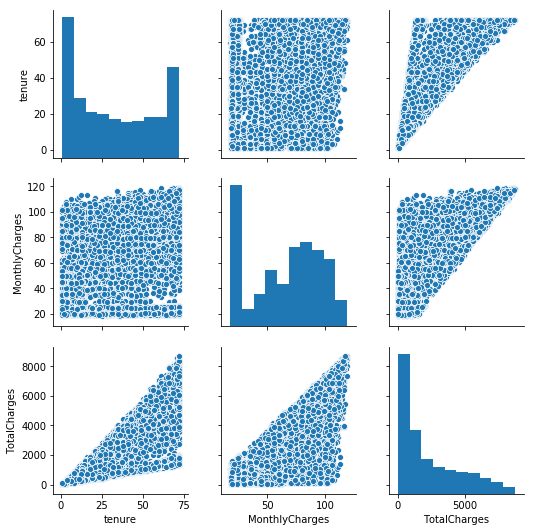

In [871]:
sns.pairplot(df[cont_col])

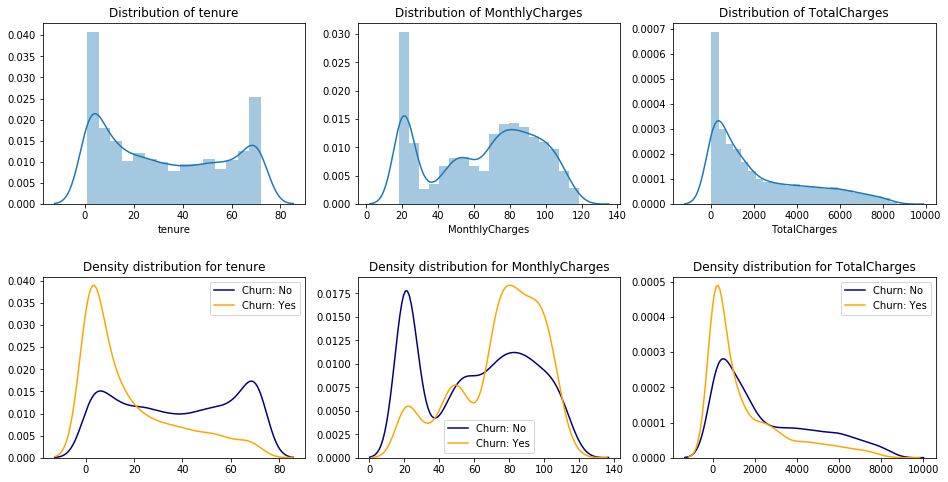

In [899]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 3, 1)
sns.distplot(df["tenure"])
plt.title("Distribution of tenure")

plt.subplot(2, 3, 2)
sns.distplot(df["MonthlyCharges"])
plt.title("Distribution of MonthlyCharges")

plt.subplot(2, 3, 3)
sns.distplot(df["TotalCharges"])
plt.title("Distribution of TotalCharges")

plt.subplot(2, 3, 4)    
plt.title("Density distribution for tenure")
ax0 = sns.kdeplot(df_viz[df_viz['Churn'] == "No"]["tenure"].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df_viz[df_viz['Churn'] == "Yes"]["tenure"].dropna(), color= 'orange', label= 'Churn: Yes')

plt.subplot(2, 3, 5)    
plt.title("Density distribution for MonthlyCharges")
ax0 = sns.kdeplot(df_viz[df_viz['Churn'] == "No"]["MonthlyCharges"].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df_viz[df_viz['Churn'] == "Yes"]["MonthlyCharges"].dropna(), color= 'orange', label= 'Churn: Yes')

plt.subplot(2, 3, 6)    
plt.title("Density distribution for TotalCharges")
ax0 = sns.kdeplot(df_viz[df_viz['Churn'] == "No"]["TotalCharges"].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df_viz[df_viz['Churn'] == "Yes"]["TotalCharges"].dropna(), color= 'orange', label= 'Churn: Yes')


We can conclude that:

- Recent clients are more likely to churn
- Clients with higher MonthlyCharges are also more likely to churn

### Categorical columns

In [29]:
cat_col = list(df.select_dtypes(["object"]).columns)
cat_col

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [30]:
cat_col.append(df["SeniorCitizen"].name)
cat_col

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen']

In [31]:
df[cat_col].head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,0
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,0
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,0
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,0
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,0


### Categorical variables encoding

### Encoding the binary categorical columns

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat_col:
    if df[col].nunique() == 2:
        le.fit(df[col])
        df[col] = le.transform(df[col])
        

In [33]:
df.head(n=2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0


### Encoding the non-binary categorical columns

In [34]:
df_dummies = pd.get_dummies(df.iloc[:, 1:])

In [35]:
df = pd.concat([df["customerID"], df_dummies], axis=1)

In [36]:
df.head(n=2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,0,1,0,0,0,0,1


My dataframe is now all numerical values !

In [37]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.592719,64.798208,2283.300441,0.265785,...,0.395478,0.216155,0.388367,0.551052,0.209329,0.239619,0.219283,0.216297,0.336320,0.228100
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.491363,30.085974,2266.771362,0.441782,...,0.488988,0.411650,0.487414,0.497422,0.406858,0.426881,0.413790,0.411748,0.472483,0.419637
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.587500,401.450000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.862500,3794.737500,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Machine Learning

In [38]:
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

## Scaling

In [39]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X, y)
X_scaled = sc.transform(X)

In [40]:
X_scaled.shape

(7032, 40)

## Splitting X, y

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

## Predicting

I am going to test different algorithms and see how they perform on this dataset.

#### Random Forest

##### No PCA

In [42]:
from sklearn.ensemble import RandomForestClassifier
    
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', class_weight='balanced')

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [43]:
y_pred_rf = rf.predict(X_test)

In [44]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred_rf)

0.5527950310559007

In [45]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1038
           1       0.65      0.48      0.55       369

   micro avg       0.80      0.80      0.80      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.80      0.78      1407



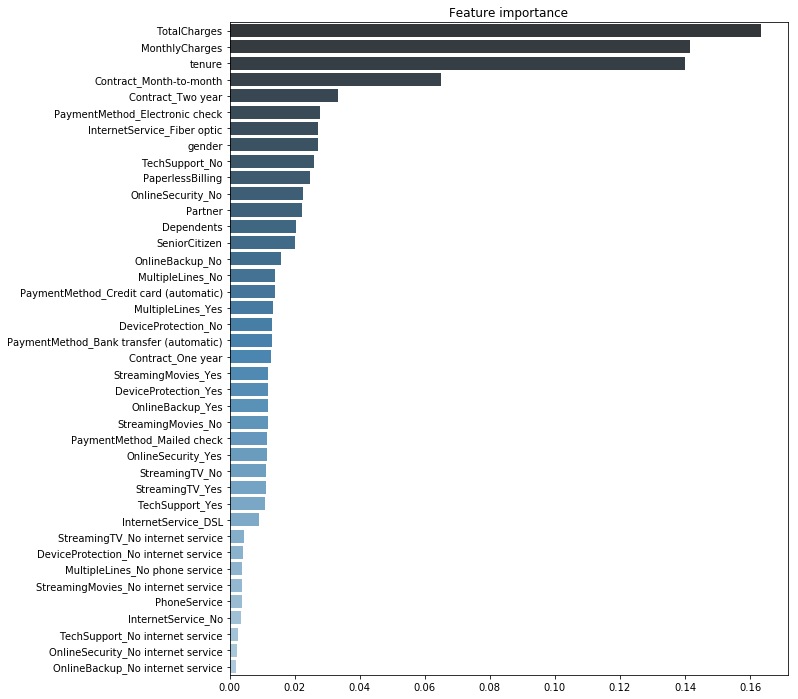

In [46]:
imp = pd.Series(data=rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

##### Recap Random Forest with no PCA

In [63]:
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

results = pd.DataFrame([["Random Forest without PCA", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

In [64]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795


##### With PCA

In [47]:
X_train_centered = X_train - X_train.mean()
X_test_centered = X_test - X_test.mean()

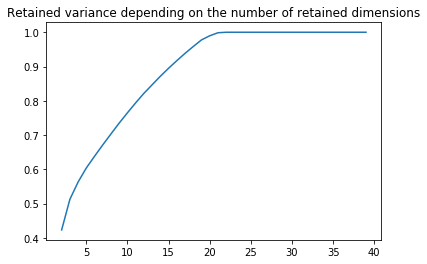

In [49]:
from sklearn.decomposition import PCA

lst = []

for n in range(2, 40):
    
    pca = PCA(n_components=n)
    pca.fit(X_train_centered)
    
    lst.append(pca.explained_variance_ratio_.sum())
    
plt.figure()

plt.plot(range(2, 40), lst)
plt.title("Retained variance depending on the number of retained dimensions")

plt.show()


In [51]:
# Let's try a pca with n_components = 22

pca_ = PCA(n_components=22)
X_train_pca = pca_.fit(X_train_centered).transform(X_train_centered)
X_test_pca = pca_.fit(X_test_centered).transform(X_test_centered)

rf_pca = RandomForestClassifier(n_estimators=200, criterion='entropy')

rf_pca.fit(X_train_pca, y_train)
y_pred_rfc_pca = rf_pca.predict(X_test_pca)

f1_score(y_test, y_pred_rfc_pca)

0.4307116104868913

Dimensionality reduction does not improve the performance of the model ; on the contrary, it worsens it a lot. Thus, I will not be using PCA going forward.

##### Recap Random Forest with PCA

In [65]:
acc = accuracy_score(y_test, y_pred_rfc_pca)
prec = precision_score(y_test, y_pred_rfc_pca)
rec = recall_score(y_test, y_pred_rfc_pca)
f1 = f1_score(y_test, y_pred_rfc_pca)

results_rf_pca = pd.DataFrame([["Random Forest with PCA", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

In [66]:
results = results.append(results_rf_pca, ignore_index=True)

In [67]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712


#### Adaboost

In [68]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.5)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

f1_score(y_test, y_pred_ada)

0.6080476900149031

In [69]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1038
           1       0.68      0.55      0.61       369

   micro avg       0.81      0.81      0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407



##### Recap Adaboost

In [73]:
acc = accuracy_score(y_test, y_pred_ada)
prec = precision_score(y_test, y_pred_ada)
rec = recall_score(y_test, y_pred_ada)
f1 = f1_score(y_test, y_pred_ada)

results_ada = pd.DataFrame([["Adaboost", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

In [74]:
results = results.append(results_ada, ignore_index=True)

In [78]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
3,Adaboost,0.813077,0.675497,0.552846,0.608048


#### SVM

In [80]:
from sklearn.svm import SVC

svc = SVC(C=0.1, class_weight={0:0.26, 1:0.74})
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

f1_score(y_test, y_pred_svc)

0.616326530612245

In [81]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1038
           1       0.49      0.82      0.62       369

   micro avg       0.73      0.73      0.73      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.73      0.75      1407



##### Recap SVM

In [82]:
acc = accuracy_score(y_test, y_pred_svc)
prec = precision_score(y_test, y_pred_svc)
rec = recall_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)

results_svc = pd.DataFrame([["SVC", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

results = results.append(results_svc, ignore_index=True)

In [83]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
2,Adaboost,0.813077,0.675497,0.552846,0.608048
3,SVC,0.732765,0.494272,0.818428,0.616327


#### Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, class_weight={0:0.26, 1:0.74})
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

f1_score(y_test, y_pred_lr)

0.6222684703433923

In [85]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1038
           1       0.51      0.81      0.62       369

   micro avg       0.74      0.74      0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.74      0.76      1407



##### Recap Logistic Regression

In [86]:
acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr)
rec = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

results_lr = pd.DataFrame([["Logistic Regression", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

results = results.append(results_lr, ignore_index=True)

In [87]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
2,Adaboost,0.813077,0.675497,0.552846,0.608048
3,SVC,0.732765,0.494272,0.818428,0.616327
4,Logistic Regression,0.742004,0.505068,0.810298,0.622268


#### GBC

In [89]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, 
                                 loss='exponential', max_depth=5)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

f1_score(y_test, y_pred_gbc)

0.5847076461769115

In [90]:
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1038
           1       0.65      0.53      0.58       369

   micro avg       0.80      0.80      0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.80      1407



##### Recap GBC

In [91]:
acc = accuracy_score(y_test, y_pred_gbc)
prec = precision_score(y_test, y_pred_gbc)
rec = recall_score(y_test, y_pred_gbc)
f1 = f1_score(y_test, y_pred_gbc)

results_gbc = pd.DataFrame([["GBC", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

results = results.append(results_gbc, ignore_index=True)

In [92]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
2,Adaboost,0.813077,0.675497,0.552846,0.608048
3,SVC,0.732765,0.494272,0.818428,0.616327
4,Logistic Regression,0.742004,0.505068,0.810298,0.622268
5,GBC,0.803127,0.654362,0.528455,0.584708


#### XGBoost

In [93]:
# scale_pos_weight = (nb of 0 - nb of 1)/nb of 1
((len(y)-sum(y))-sum(y))/sum(y)

1.7624398073836276

In [94]:
import xgboost as xgb

xg = xgb.XGBClassifier(max_depth=1, scale_pos_weight=1.76, learning_rate=0.062)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)

f1_score(y_test, y_pred_xg)

0.6508313539192399

In [98]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1038
           1       0.58      0.74      0.65       369

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.74      0.78      0.75      1407
weighted avg       0.81      0.79      0.80      1407



##### Recap XGBoost

In [99]:
acc = accuracy_score(y_test, y_pred_xg)
prec = precision_score(y_test, y_pred_xg)
rec = recall_score(y_test, y_pred_xg)
f1 = f1_score(y_test, y_pred_xg)

results_xg = pd.DataFrame([["XGBoost", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

results = results.append(results_xg, ignore_index=True)

In [103]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
2,Adaboost,0.813077,0.675497,0.552846,0.608048
3,SVC,0.732765,0.494272,0.818428,0.616327
4,Logistic Regression,0.742004,0.505068,0.810298,0.622268
5,GBC,0.803127,0.654362,0.528455,0.584708
6,XGBoost,0.791045,0.579281,0.742547,0.650831


#### LightGBM

In [104]:
import lightgbm as lgb

lg = lgb.LGBMClassifier(max_depth=2, scale_pos_weight=1.76)
lg.fit(X_train, y_train)
y_pred_lg = lg.predict(X_test)

f1_score(y_test, y_pred_lg)

0.6414634146341464

In [105]:
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1038
           1       0.58      0.71      0.64       369

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.74      0.77      0.75      1407
weighted avg       0.81      0.79      0.80      1407



##### Recap LightGBM

In [106]:
acc = accuracy_score(y_test, y_pred_lg)
prec = precision_score(y_test, y_pred_lg)
rec = recall_score(y_test, y_pred_lg)
f1 = f1_score(y_test, y_pred_lg)

results_lg = pd.DataFrame([["LightGBM", acc, prec, rec, f1]],
               columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

results = results.append(results_lg, ignore_index=True)

In [107]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
2,Adaboost,0.813077,0.675497,0.552846,0.608048
3,SVC,0.732765,0.494272,0.818428,0.616327
4,Logistic Regression,0.742004,0.505068,0.810298,0.622268
5,GBC,0.803127,0.654362,0.528455,0.584708
6,XGBoost,0.791045,0.579281,0.742547,0.650831
7,LightGBM,0.791045,0.583149,0.712737,0.641463


# Conclusion

In [109]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest without PCA,0.795309,0.647273,0.482385,0.552795
1,Random Forest with PCA,0.783937,0.696970,0.311653,0.430712
2,Adaboost,0.813077,0.675497,0.552846,0.608048
3,SVC,0.732765,0.494272,0.818428,0.616327
4,Logistic Regression,0.742004,0.505068,0.810298,0.622268
5,GBC,0.803127,0.654362,0.528455,0.584708
6,XGBoost,0.791045,0.579281,0.742547,0.650831
7,LightGBM,0.791045,0.583149,0.712737,0.641463


Best algorithm = XGBoost

Best f1_score = 0.6508